# Simple example how to run PlutoSDR on Sionna

The code, excluding the Software-Defined Radio (SDR) functions, is sourced from the Sionna GitHub repository. Adaptations have been made to integrate the SDR radio into the system. Specifically, the PlutoSDR is utilized as a substitute for channel simulation. It takes input from the Sionna modulator and produces a TensorFlow tensor, configured for seamless integration with the Sionna demodulator.

Limitations:

- Batch size must be 1.
- This version supports SISO 1T1R, single full-duplex device

Important: Transmitting anything requires an appropriate license; failure to have one may result in legal consequences.

Typically the duration of execution is approximtely 25ms per OFDM block, but with graphs (debug=True), it can take approximately 2.5sec.

In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

2025-09-16 14:22:54.951935: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of GPUs available : 1
Only GPU number 0 used.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Model
import sionna

# Updated imports for Sionna 1.x (migrated from 0.16)
from sionna.phy.mimo.stream_management import StreamManagement
from sionna.phy.ofdm.resource_grid import ResourceGrid, ResourceGridMapper
from sionna.phy.ofdm.channel_estimation import LSChannelEstimator
from sionna.phy.ofdm.equalization import LMMSEEqualizer
from sionna.phy.ofdm.modulator import OFDMModulator
from sionna.phy.ofdm.demodulator import OFDMDemodulator
from sionna.phy.ofdm.precoding import RZFPrecoder, RemoveNulledSubcarriers
from sionna.phy.fec.ldpc.encoding import LDPC5GEncoder
from sionna.phy.fec.ldpc.decoding import LDPC5GDecoder
from sionna.phy.mapping import Mapper, Demapper, BinarySource
from sionna.phy.utils.misc import ebnodb2no, sim_ber
from sionna.phy.utils import PlotBER
from sionna.phy.utils.metrics import compute_ber

print(f"Sionna version: {sionna.__version__}")

# System configuration
num_tx = 1                    # Number of transmit antennas  
num_streams_per_tx = 1        # Number of streams per transmitter
num_rx = 1                    # Number of receive antennas

# OFDM Resource Grid parameters
num_ofdm_symbols = 14         # Number of OFDM symbols per slot (typical LTE/5G)
fft_size = 128                 # FFT size (number of subcarriers)
subcarrier_spacing = 15e3     # Subcarrier spacing in Hz (30 kHz for 5G NR)
cyclic_prefix_length = 7     # Cyclic prefix length in samples
num_guard_carriers = [5, 6]   # Number of guard carriers [left, right]
dc_null = True                # Whether to null the DC subcarrier
pilot_ofdm_symbol_indices = [2,11]  # OFDM symbols containing pilots
pilot_pattern = "kronecker"  


Sionna version: 1.1.0


### Stream Management <a class="anchor" id="Stream-Management"></a>

In [3]:
# Create an RX-TX association matrix
rx_tx_association = np.array([[1]])

# Instantiate a StreamManagement object
sm = StreamManagement(rx_tx_association, num_streams_per_tx)

### OFDM Resource Grid & Pilot Pattern <a class="anchor" id="OFDM-Resource-Grid-&-Pilot-Pattern"></a>

In [4]:
rg = ResourceGrid(num_ofdm_symbols=num_ofdm_symbols,
                  fft_size=fft_size,
                  subcarrier_spacing=subcarrier_spacing,
                  num_tx=num_tx,
                  num_streams_per_tx=num_streams_per_tx,
                  cyclic_prefix_length=cyclic_prefix_length,
                  num_guard_carriers=num_guard_carriers,
                  dc_null=dc_null,
                  pilot_pattern=pilot_pattern,
                  pilot_ofdm_symbol_indices=pilot_ofdm_symbol_indices)

I0000 00:00:1757989377.210082  349996 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5508 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


In [5]:
num_bits_per_symbol = 6 # 256QAM modulation
coderate = 0.5 # Code rate
n = int(rg.num_data_symbols*num_bits_per_symbol) # Number of coded bits
k = int(n*coderate) # Number of information bits

# The binary source will create batches of information bits
binary_source = BinarySource() 

# The encoder maps information bits to coded bits
encoder = LDPC5GEncoder(k, n)

# The mapper maps blocks of information bits to constellation symbols
mapper = Mapper("qam", num_bits_per_symbol)

# The resource grid mapper maps symbols onto an OFDM resource grid
rg_mapper = ResourceGridMapper(rg)

# OFDM modulator and demodulator
modulator = OFDMModulator(rg.cyclic_prefix_length)
demodulator = OFDMDemodulator(rg.fft_size, 0, rg.cyclic_prefix_length)

# This function removes nulled subcarriers from any tensor having the shape of a resource grid
remove_nulled_scs = RemoveNulledSubcarriers(rg)

# The LS channel estimator will provide channel estimates and error variances
ls_est = LSChannelEstimator(rg, interpolation_type="nn")

# The LMMSE equalizer will provide soft symbols together with noise variance estimates
lmmse_equ = LMMSEEqualizer(rg, sm)

# The demapper produces LLR for all coded bits
demapper = Demapper("app", "qam", num_bits_per_symbol)

# The decoder provides hard-decisions on the information bits
decoder = LDPC5GDecoder(encoder, hard_out=True)

### import PlutoSDR library for Sionna use

PlutoSDR parameters:
- SDR_TX_IP: IP address of the PlutoSDR
- SDR_TX_FREQ: Transmit frequency in Hz
- SDR_TX_BANDWIDTH: Transmit bandwidth in Hz
- SampleRate: Sample rate in Hz

In [6]:
import SDR_Sionna_1T1R as sdr
from SDR_config import SDRConfig, create_debug_config

SampleRate = rg.fft_size*rg.subcarrier_spacing # sample rate

# Create SDR configuration - you can customize parameters here
# Option 1: Use default configuration
# config = SDRConfig()

# Option 2: Create custom configuration with specific parameters  
config = SDRConfig(
    sdr_tx_ip="ip:192.168.10.190",
    sdr_tx_freq=435.1e6,
    rf_bandwidth_multiplier=1.3,
    sdr_rx_gain=10,
    debug=True,
    save_plots=True
)

# Option 3: Use convenience function for debug configuration
# config = create_debug_config(sdr_tx_ip="ip:192.168.10.190", sdr_tx_freq=435.1e6)

# Start the radio. Note, radio transmissions are only allowed with appropriate licenses!!!
########################################################################################################################################################
SDR1 = sdr.SDR(SampleRate=SampleRate, config=config)
########################################################################################################################################################


## Eager mode example with SDR 

### Single run in debug mode for SDR debug graphs

sdr.SDR input parameters:
- SAMPLES: symbols output from sionna modulator
- SDR_TX_GAIN: transmitter gain. 0dB is maximum
- add_td_symbols: number of additional symbols to cater for delay spread. Sionna demodulator seems to expect 16 symbols.
- debug: True for pretty(-ish) graphs

sdr.SDR output parameters x_xdr (see below):
- x_sdr[0] : samples
- x_sdr[1] : SINR estimate
- x_sdr[2] : actual TX_Gain setting in SDR
- x_sdr[3] : actual RX_Gain setting in SDR
- x_sdr[4] : Attempts - the algorithm tries to send again with increased power if correlation is not found
- x_sdr[5] : Pearson R - the correlation between transmitted and received signals
- x_sdr[6] : SDR time - how long it took to input the samples, transmit, receive, and output the samples. Typically ~23ms in my test set up, around 1sec if debug=True and graphs are created.

2025-09-16 14:23:00.932752: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


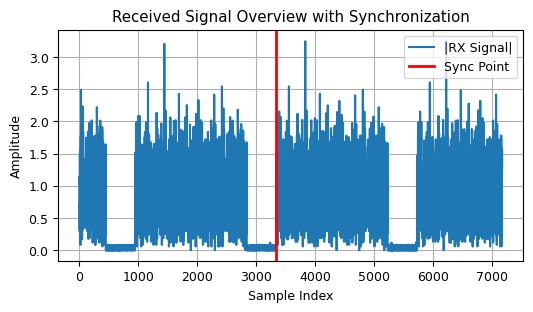

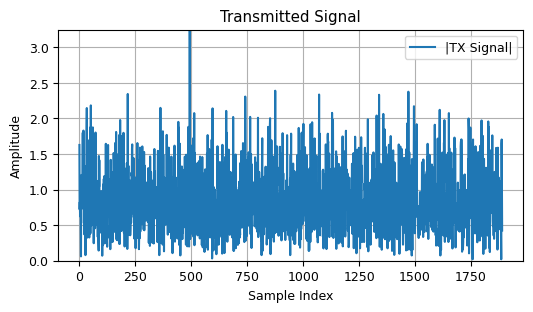

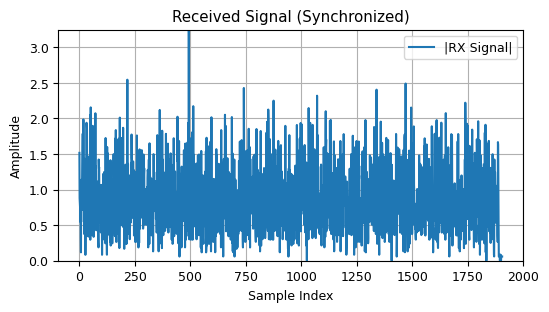

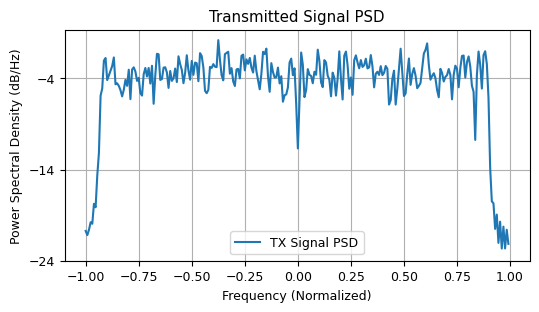

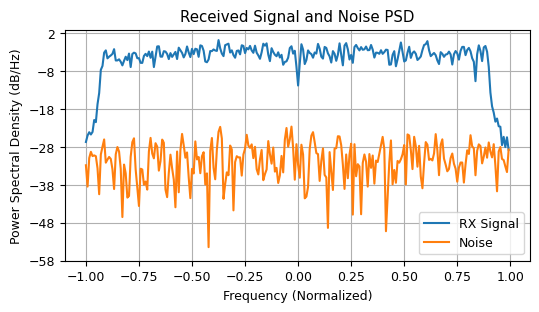

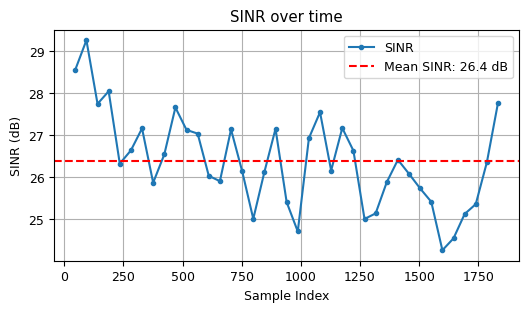

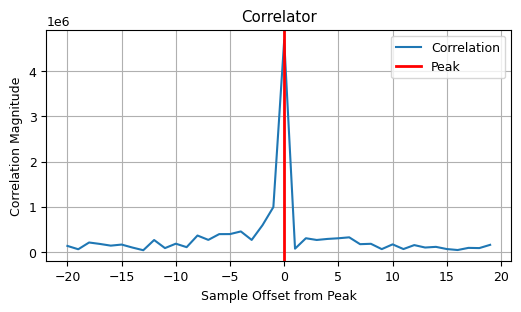

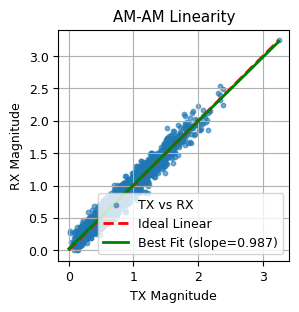

I0000 00:00:1757989383.378321  349996 cuda_solvers.cc:175] Creating GpuSolver handles for stream 0x58f8772fc2b0


BER: 0.000, TX_Gain: -16dB, RX_Gain: 10dB, Attempts: 1, relative correlation: 99.09, SINR 26.4dB, SDR time: 4383ms


In [7]:
batch_size = 1 # We pick a small batch_size as executing this code in Eager mode could consume a lot of memory
b = binary_source([batch_size, 1, rg.num_streams_per_tx, encoder.k])
c = encoder(b)
x = mapper(c)
x_rg = rg_mapper(x)

# OFDM modulation with cyclic prefix insertion
x_time = modulator(x_rg)

########################################################################################################################################################
# All parameters now come from config, but can still be overridden if needed
x_sdr = SDR1(SAMPLES = x_time, add_td_symbols = 16, threshold = 25) # transmit, threshold = 0 => max_correlation in use
# Alternative: override config parameters: x_sdr = SDR1(SAMPLES = x_time, SDR_RX_GAIN=10, add_td_symbols = 16, threshold = 25, debug=True,  power_max_tx_scaling=1, minSINR=5, maxSINR=30)
########################################################################################################################################################

y = demodulator(x_sdr[0]) # received samples in tf Sionna compatible format

no = ebnodb2no((x_sdr[1]), num_bits_per_symbol, coderate, rg) # SINR estimate
h_hat, err_var = ls_est (y, no) 

x_hat, no_eff = lmmse_equ(y, h_hat, err_var, no)
llr = demapper(x_hat, no_eff)
b_hat = decoder(llr)
ber = compute_ber(b, b_hat)

print(f"BER: {ber:1.3f}, TX_Gain: {x_sdr[2]}dB, RX_Gain: {x_sdr[3]}dB, Attempts: {x_sdr[4]}, relative correlation: {x_sdr[5]:1.2f}, SINR {x_sdr[1]:1.1f}dB, SDR time: {x_sdr[6]*1000:1.0f}ms")